## Part 3 Systematics

Other tutorials
* See also [Hannu's tutorial](https://github.com/hpparvi/exo_tutorials/blob/master/01_broadband_parameter_estimation.ipynb)
* Bayesian and Frequentist Statistics Explained [J. van der Plas blog](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
* Data Analysis Recipes: Fitting a model to data ([Hogg et al.](https://arxiv.org/abs/1008.4686))

In [1]:
#check python version
!python --version

Python 3.6.2 :: Continuum Analytics, Inc.


In [2]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'py3'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=18

## import data

In [4]:
from glob import glob

datadir = '.'
path    = os.path.join(datadir,'TRAPPIST*.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list

['./TRAPPIST-1_rad13_temp1.csv',
 './TRAPPIST-1_rad13_temp2.csv',
 './TRAPPIST-1_rad13_temp3.csv']

In [5]:
df=pd.read_csv(file_list[2], delimiter=',', parse_dates=True)
df = df.drop('Unnamed: 0',axis=1)

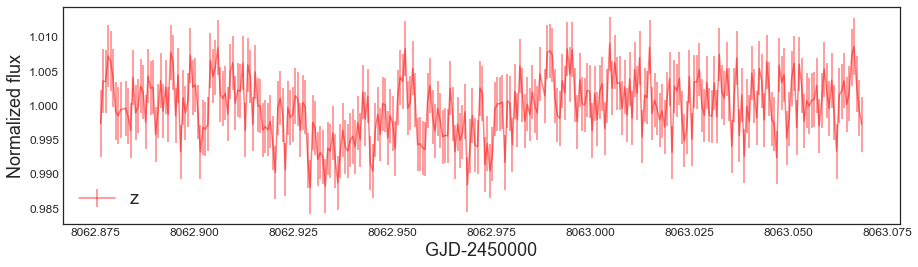

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

fig,ax = pl.subplots(1,1,figsize=(15,4))
    
time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

ax.errorbar(time, flux, yerr=err, label="z",color="r", alpha=0.5)
ax.set_ylabel('Normalized flux', fontsize=fontsize)
              
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('GJD-2450000', fontsize=fontsize)

## setting-up the transit model 

```
* t:     time
* k:     Rp/Rs: planet-star radius ratio (=k^2: transit depth)
* u1,u2: limb-darkening coefficients
* tc:    transit center
* P:     orbital period
* a_s:   a/Rs: scaled semi-major axis
* i:     inclination
* e:     eccentricity
* w:     argument of periastron
* c:     contamination factor
```

See transit parameters for HAT-P-44b at [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [7]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters,period_d, period_e, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k_d,tc_d,a_d,b_d,k_e,tc_e,a_e,b_e,q1,q2 = parameters
    
    #compute inclination
    inc_d   = np.arccos(b_d/a_d)
    inc_e   = np.arccos(b_e/a_e)
    #convert u to q
    u1,u2 = q_to_u(q1_, q2_)
    #evaluate the model
    m = 1-(1-model.evaluate(time, k_d, (u1,u2), tc_d, period_d, a_d, inc_d))-(1-model.evaluate(time, k_e, (u1,u2), tc_e, period_e, a_e, inc_e))
    
    return m

In [8]:
from astropy import units as u

#values come from S.Wang et al.(2017) 
_tce  = 8062.9449 
_Pe   = 6.099570 #pm 0.000091 (days)
_ae   = 0.02818 #semimajor axis (AU)
_ee   = 0.007 #pm 0.003
_Rpe  = 0.918 #pm0.039 (R_earth)

#from M.Gillon et al.(2017)
_be   = 0.12 #+0.11/-0.09
_ince = np.deg2rad(89.86) #+0.10/-0.12

_Rs = 0.117 #pm 0.0036(Rsun)
k_e = _Rpe/_Rs/u.Rsun.to(u.Rearth)

a_s_e= _ae/_Rs/u.Rsun.to(u.au)

tc_0e      = 8062.930


#values come from S.Wang et al.(2017) 
_tcd  = 8062.97518 
_Pd   = 4.04982 #pm 0.00017(days)
_ad   = 0.02145 #semimajor axis (AU)
_ed   = 0.003 #+0.004 -0.003
_Rpd  = 0.772 #pm 0.030 (R_earth)

#from M.Gillon et al.(2017)
_bd   = 0.17 #pm0.11
_incd = np.deg2rad(89.75) #pm0.16

k_d = _Rpd/_Rs/u.Rsun.to(u.Rearth)

a_s_d= _ad/_Rs/u.Rsun.to(u.au)

tc_0d      = 8062.970

In [9]:
import limbdark as ld

teff, uteff = 2559,  50 #from M.Gillon(2017)
logg, ulogg = 4.39, 0.03 #from Exoplanets Data Explorer
feh, ufeh   = 0.04,  0.08 #from M.Gillon(2017)

ldc_list     = []
ldc_err_list = []

ldc = ld.claret("z*", teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
#ldc = u1_,u1err, u2_,u2err

#save in list
#u1,u2
ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
#uncertainties
ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

## Optimizing transit parameters: Frequentist approach

### 1. Maximum Likelihood Estimation (MLE)

See part3; See part5 for Bayesian approach

In [10]:
import scipy.optimize as op

def obj(theta, p_d, p_e, t, f, err):
    '''
    objective function: chi-squared
    '''
    m = transit_model_q(theta, p_d, p_e, t, model=MandelAgol())
    
    return np.sum(((m-f)/err)**2)

def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

rms before: 0.0041
rms after: 0.0040



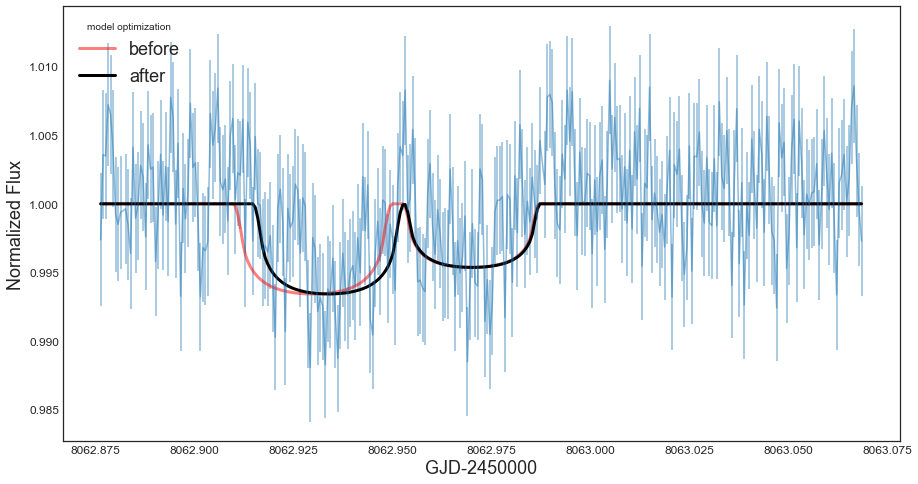

In [11]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

optimized_transit_params = {} 
    
time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]
    
pl.errorbar(time, flux, yerr=err, alpha=0.5) 

#compute q from u found in limbdark
q1_,q2_ = u_to_q(ldc[0],ldc[2])

#transit_model_q(parameters_d,parameters_e,q1,q2, period_d, period_e, time, model=MandelAgol()):
#compute flux before optimization
transit_params_d     = [k_d,tc_0d,a_s_d,_bd]
transit_params_e     = [k_e,tc_0e,a_s_e,_be]

transit_params=transit_params_d+transit_params_e+[q1_,q2_]

transit_model_before  = transit_model_q(transit_params, _Pd,_Pe, time)
#rms before
rms_before = rms(flux,transit_model_before)
print('rms before: {:.4f}'.format(rms_before))

#optimize parameters
result = op.minimize(obj, transit_params, args=(_Pd,_Pe, time, flux, err), method='nelder-mead')
    
#compute flux after optimization
transit_params_after     = np.copy(result.x)
transit_model_after  = transit_model_q(transit_params_after, _Pd,_Pe, time)
#rms after
rms_after = rms(flux,transit_model_after)
print('rms after: {:.4f}\n'.format(rms_after))
    
#plot transit models
#before (faint red)
ax.plot(time, transit_model_before, 'r-', lw=3, alpha=0.5)
#after (black)
ax.plot(time, transit_model_after, 'k-', lw=3, alpha=1)
ax.legend(fontsize=fontsize)
    
#dict of optimized transit parameters to be used later
optimized_transit_params = transit_params_after
    
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('GJD-2450000', fontsize=fontsize)
ax.legend(['before','after'], title='model optimization',fontsize=fontsize)

In [12]:
optimized_transit_params

array([  6.04923560e-02,   8.06297026e+03,   3.94226049e+01,
         1.70000311e-01,   7.19324323e-02,   8.06293397e+03,
         5.43809844e+01,   1.20000165e-01,   8.48978603e-01,
         2.02572134e-01])

## Optimizing transit parameters: Bayesian approach

See part6.

---

## Modeling systematics

Transit light curve contains various information. Aside from the transit signal, it also (generally) contains systematic noise and photometric noise.

![img](images/modeling.png)

Systematics is a catch-all term that accounts for the noise in the light curve except photometric noise. Systematics is largely composed of (but not limited to):

* stellar variability
* instrumental noise (detector, tracking problems, etc.)
* atmospheric variability
* etc.

What we would like to do is to model all of them together and at the same time (i.e simultaneous) to get the best fit parameters; not model them separately by removing systematic first and then fitting for transit parameters (or vice-versa). We will show how to do simultaneous modeling in the mcmc part (part6) of this tutorial series. 

Let's try to understand first how to model the systematics separately from the transit signal. It must be emphasized rightaway that modeling transit and systematics separately is usually wrong because we do not have complete complete understanding of either the transit or systematics component of the light curve.

For now, let's assume that the transit parameters we obtained after optimization are correct. We will remove the transit signal from the light curve so that the residual signal is assumed to contain the systematics only.

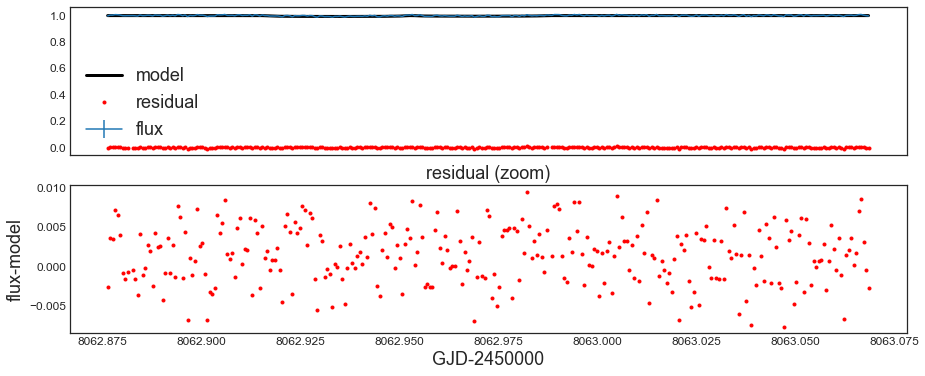

In [14]:
time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

#flux model with optimized transit parameters
transit_model = transit_model_q(optimized_transit_params, _Pd,_Pe, time)

fig,ax = pl.subplots(2,1,figsize=(15,6), sharex=True)

ax[0].errorbar(time, flux, yerr=err)
ax[0].plot(time, transit_model, 'k-', lw=3, label='model')


#plot residual
offset= 0
resid = flux-transit_model #引き算か！？割り算か！？
ax[0].plot(time, resid+offset, 'r.', label='residual', lw=2)
ax[0].legend(fontsize=fontsize)

#plot residual again, but in a new axis
ax[1].plot(time, resid, 'r.', lw=2)
rms(flux,transit_model)
ax[1].set_title('residual (zoom)',fontsize=fontsize)
ax[1].set_ylabel('flux-model',fontsize=fontsize)
ax[1].set_xlabel('GJD-2450000', fontsize=fontsize)

## computing systematics parameters: Frequentist approach

We can model the systematics in two general ways:
* [parametric](https://en.wikipedia.org/wiki/Parametric_model)
* [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics)

A parametric model basically means the model has given finite set of parameters. A common example of a parametric systematics model is a linear combination of constant coefficients and auxiliary observables:
$$
y_i=w_0+\sum_{i=0}w_iX_i \\
y_i=y_{\rm{data}}-y_{\rm{transit\;model}} = w_0+w_1X_1+ \ldots + w_nX_n
$$
where $y_i$ is the function we want to model (e.g. residual which contains systematics), $X_i$ is the set of auxiliary observables (e.g. centroid position of target, airmass, etc.), and $w_i$ is the set of coefficients (or weights) of $X_i$.

Using Maximum Likelihood Estimation (MLE) to compute/optimize $w$ is not recommended (and will most likely fail) because we don't have good guesses for the initial values of the constant coefficients. Remember in our transit modeling, we have good guesses for limb-dakening coefficients, transit center, etc.

A non-parametric model basically means the model has infinite parameters and usually has no auxiliary parameters needed to model the data. An example of a non-parametric model used frequently to model transit light curves is the [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) model which we will not disccuss in this tutorial (let's ask John!). For simplicity, a simpler non-parametric model using Radial Basis Function is shown (in the Appendix) to compare with the result of the parameteric modeling.

---

### least-squares/ $\chi^2$-square (Linear algebra)

![img](images/linalg.jpg)

Let's implement ordinary least square/ chi-square using linear algebra. 

Our aim is to compute the weights $w$ (or coefficients of the systematics model):
$$
y_i=w_0+\sum_{i=1}w_iX_i
$$
or in vector form:
$$
y= X \cdot w
$$

Solving for $w$,
$$
X^T \cdot y = X^T \cdot X \cdot w \\
(X^T \cdot X)^{-1} \cdot X^T \cdot y = w
$$
where $y$ is the function we want to model (e.g. residual which contains systematics) and $X$ is the "[design matrix](https://en.wikipedia.org/wiki/Design_matrix)" that contains auxiliary the observables.

$X$ can be composed of any auxiliary observables such as
```
* target centroid           e.g. dx(pix), dy(pix)
* airmass
* sky background            e.g. sky(ADU)
* fwhm                      e.g. fwhm(pix)
* peak flux                 e.g. peak(ADU)
* error or flux uncertainty e.g. err(r=11.0)
* color                     e.g. flux_g/flux_r


* powers of [param]         e.g. dx^2, dy^2
* cross-term                e.g. dx*dy
* etc.
```

We can use the `numpy` functions below to solve the equation above. 
* `np.dot ` for dot product
* `np.linalg.inv ` for inverse
* `[vector].T ` for transpose

However, we will use `np.linalg.solve` (instead of `np.linalg.inv`) to avoid problems related with matrices that cannot be inverted. See details in [StackOverflow](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li).

Let's construct $X$ for the z-band for now.

In [15]:
df.columns

Index(['GJD-2450000', 'flux', 'err', 'airmass', 'sky', 'dx', 'dy'], dtype='object')

In [16]:
dx        = df['dx']
dy        = df['dy']
airmass   = df['airmass']
sky       = df['sky']
#fwhm      = df['fwhm(pix)']
#peak      = df['peak(ADU)']
err       = df['err']
flux      = df['flux']
dx.size

304

### Simple systematics model

First, use only the shift/displace of centroids in the detector: dx and dy. We can concatenate the them using `np.c_`

In [17]:
X = np.c_[dx,dy]
#show the first 10 values
X[:10]

array([[-0.027, -2.954],
       [-0.084, -2.454],
       [-0.13 , -1.302],
       [-0.433,  0.046],
       [ 0.116, -1.458],
       [-0.694, -1.532],
       [-0.494, -2.036],
       [ 0.183, -0.653],
       [ 0.05 , -0.552],
       [-0.455, -0.98 ]])

In [23]:
X[1].size

2

Then, compute weights (coefficients) $w$ of systematic model using the residual.

In [19]:
resid  = flux-transit_model
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, resid))
w

array([-0.00028111, -0.00074669])

Note that the number of components of $w$ should be equal to the number of observables (or columns) in $X$

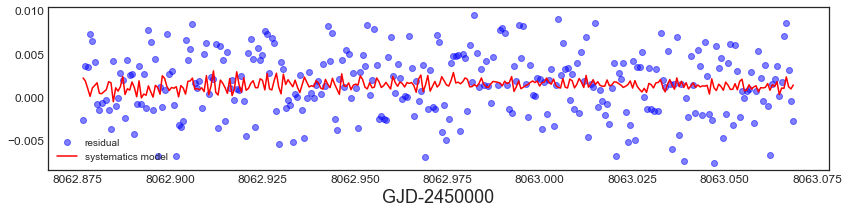

In [20]:
fig, ax   = pl.subplots(1,1,figsize=(14,3))
sys_model = np.dot(X,w)

ax.plot(time, resid, 'bo', alpha=0.5, label='residual')
ax.plot(time, sys_model, 'r-', label='systematics model')
ax.set_xlabel('GJD-2450000', fontsize=fontsize)
pl.legend()

Let's see more plots.

rms of residual:
0.0040
rms of residual w/o systematics:
0.0015
BIC:
313.1010


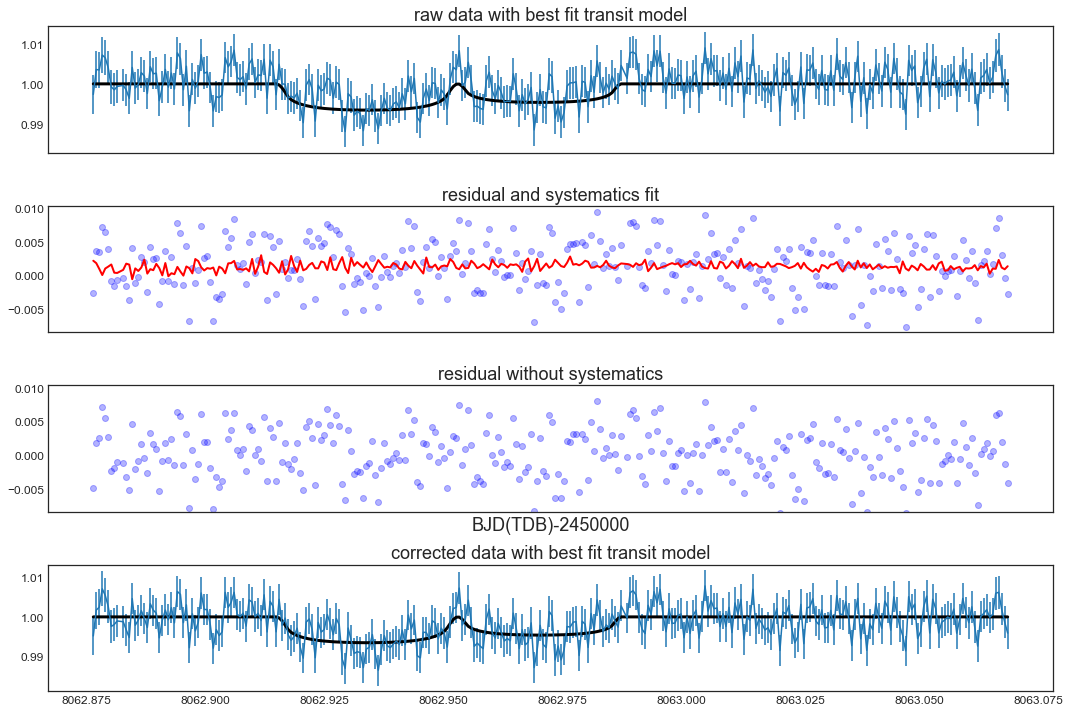

In [25]:
fig,ax = pl.subplots(4,1,figsize=(15,10), sharex=True)

#top: raw data
ax[0].errorbar(time, flux, yerr=err)
ax[0].plot(time, transit_model, 'k-', lw=3, label='model')
ax[0].set_title('raw data with best fit transit model', fontsize=fontsize)

#middle: residual
resid = flux-transit_model
ax[1].plot(time, resid, 'bo', alpha=0.3, label='residual')
ax[1].plot(time, sys_model, 'r-', lw=2, label='systematics')
ax[1].set_title('residual and systematics fit', fontsize=fontsize)

#bottom: residual without systematics
resid_wo_sys = flux-transit_model-sys_model
ax[2].plot(time, resid_wo_sys, 'bo', alpha=0.3)
ax[2].set_title('residual without systematics', fontsize=fontsize)
ax[2].set_ylim(*ax[1].get_ylim()) #make y-axis limits of ax[2] like in ax[1]
ax[2].set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)

#compute rms
rms1 = rms(flux, transit_model)
rms2 = rms(resid, resid_wo_sys)
print('rms of residual:\n{:.4f}'.format(rms1))
print('rms of residual w/o systematics:\n{:.4f}'.format(rms2))

#compute BIC
num_d=flux.size
num_p=X[1].size
xisq = np.sum(((flux-transit_model)/err)**2)
BIC = xisq + num_p * np.log(num_d)
print('BIC:\n{:.4f}'.format(BIC))

#corrected lightcurve
ax[3].errorbar(time, flux-sys_model, yerr=err)
ax[3].plot(time, transit_model, 'k-', lw=3, label='model')
ax[3].set_title('corrected data with best fit transit model', fontsize=fontsize)
fig.tight_layout()

The systematic model (red line) above does not fit the residuals (blue points).

![img](images/monkey.gif)

Once stellar systematics is removed, the residual should in principle be pure random or uncorrelated noise (a.k.a. "white noise"). We can check is residual above contains only white noise by computing the autocorrelation of the residual.

We can visualize autocorrelation using `pandas.plotting.autocorrelation_plot`

To quote,

Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random, then one or more of the autocorrelations will be siginicantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% (dashed) confidence bands.

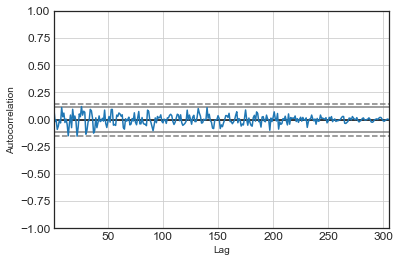

In [28]:
import pandas as pd

resid_wo_sys = flux - transit_model - sys_model
pd.plotting.autocorrelation_plot(resid_wo_sys)

Certainly, using `dx` and `dy` in $X$ is not enough because the autocorrelation plot above shows significant correlated noise still present in the residual. Let's try to use other set of auxiliary observables, aside from dx and dy.

What is the **best set** of auxiliary vector to use?

![img](images/auxvec.jpg)

There is no rule on the best/ correct auxiliary observable to put in $X$. But may be it is useful to use those vectors that are correlated with the data that we want to model. `seaborn` is another library with useful visualization. `seaborn.pairplot` can be used to quickly visualize correlation among variables as shown below.

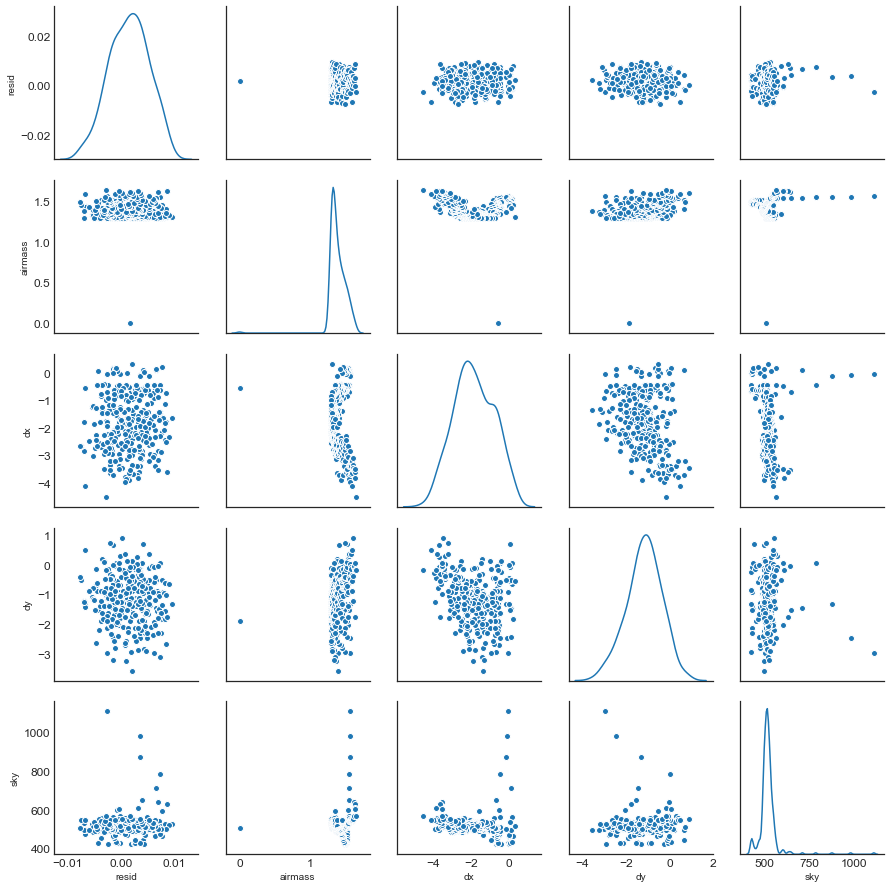

In [29]:
import seaborn as sb
sb.set_style('white')

df['resid']=resid #flux-transit_model
sb.pairplot(df.dropna(), 
            vars=['resid','airmass','dx','dy', 'sky'], 
            diag_kind='kde')

From the pairplots above, it seems reasonable to use airmass and sky; others appear to be uncorrelated with the residual. Let's do trial and error below until we get a significant reduction in rms error. We will also verify our result using autocorrelation plot.

In [21]:
df

,GJD-2450000,flux,err,airmass,sky,dx,dy
0,8062.876429,0.997372,0.004839,1.5601,1109.5,-0.027,-2.954
1,8062.877054,1.003590,0.004729,1.5560,979.8,-0.084,-2.454
2,8062.877679,1.003489,0.004581,1.5516,875.4,-0.130,-1.302
3,8062.878316,1.007227,0.004478,1.5472,785.1,-0.433,0.046
4,8062.878941,1.006522,0.004346,1.5433,710.6,0.116,-1.458
5,8062.879566,1.004026,0.004253,1.5394,649.7,-0.694,-1.532
6,8062.880214,0.999233,0.004207,1.5351,601.6,-0.494,-2.036
7,8062.880839,0.998504,0.004166,1.5312,563.4,0.183,-0.653
8,8062.881453,0.999367,0.004091,1.5275,535.3,0.050,-0.552
9,8062.882078,1.001618,0.003956,0.0000,508.0,-0.566,-1.874
